# 0. Data preprocessing

### 0.1. Moved data from 'pollution_data' to 'pollution_weather'.
I moved these files becauser almost all of them has the same content in both directories. Only one of them differed from each other. Because one of them was invalid, I took the second one.

### 0.2. Invalid timestamp
A few CSV files has invalid timestamps. I checked the original dataset and found out that for sure every row contains measurements from one hour

# 1. Data preparation

In [693]:
# imports - probably not all of them will be used.

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model, tree, neighbors, model_selection
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1.2. Check files consistency
  As shown in below results one can see that number of lines in files differs. Some differences are the result of different headers size.
  Difference between years is caused by the fact, that 2016 was a leap-year.

In [3]:
from os import listdir
from os.path import isfile, join
paths = ['pollution/', 'weather/']
for p in paths:
    files = [f for f in listdir(p) if isfile(join(p, f))]
    for f in files:
        print(f, sum(1 for line in open(join(p, f), encoding = "ISO-8859-1")))

2017_NO2_1g.csv 8761
2015_O3_1g.csv 8761
2017_PM25_1g.csv 8761
2015_PM25_1g.csv 8761
2015_C6H6_1g.csv 8761
2016_O3_1g.csv 8785
data_format.txt 5
2017_C6H6_1g.csv 8761
2016_PM2.5_1g.csv 8785
2017_CO_1g.csv 8761
2016_C6H6_1g.csv 8785
2016_NOx_1g.csv 8785
2015_SO2_1g.csv 8761
2017_NOx_1g.csv 8761
2017_O3_1g.csv 8761
2015_NO2_1g.csv 8761
2016_CO_1g.csv 8785
2015_CO_1g.csv 8761
2016_SO2_1g.csv 8785
2016_NO2_1g.csv 8785
2016_PM10_1g.csv 8785
2017_SO2_1g.csv 8761
2017_PM10_1g.csv 8761
2015_NOx_1g.csv 8761
s_t_424_2017.csv 8760
data_format.txt 115
s_t_424_2016.csv 8784
s_t_424_2015.csv 8760


### 1.1. Load all datasets to one Pandas DataFrame

In [680]:
dataframes = []
years = [2015, 2016, 2017]
factors = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM25', 'PM2.5', 'PM10', 'SO2']
for y in years:
    weather = pd.read_csv('weather/s_t_424_{}.csv'.format(y), header=None, encoding = "ISO-8859-1")
    weather.columns = weather.columns.astype(str)
    weather.columns.values[29] = 'Temperature'    # From docs: index 29 is a temperature measurement
    pollutions = []
    for f in factors:
        try:
            df = pd.read_csv('pollution/{}_{}_1g.csv'.format(y, f))
            df = df.drop(columns=df.columns[0])
            df.columns = [f+'_'+x for x in list(df.columns)]
            pollutions += [df]
        except Exception as e:
            print(e)
    dataframes += [pollutions[0].join(pollutions[1:] + [weather] )]

main_df = dataframes[0].append(dataframes[1:], ignore_index=True, sort=False)
mean_day_df = main_df.groupby(main_df.index // 24).mean()

# main_df['timestamp'] = main_df[2].map(str) + '-' + \
#                         main_df[3].map(str) + '-' + \
#                         main_df[4].map(str) + '-' + \
#                         main_df[5].map(str)
# mean_day_df['timestamp'] = mean_day_df[2].map(str) + '-' + \
#                         mean_day_df[3].map(str) + '-' + \
#                         mean_day_df[4].map(str) + '-'


/home/tomasz/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


File b'pollution/2015_PM2.5_1g.csv' does not exist
File b'pollution/2015_PM10_1g.csv' does not exist
File b'pollution/2016_PM25_1g.csv' does not exist
File b'pollution/2017_PM2.5_1g.csv' does not exist


# 2. Analysis 

After data preprocessing I try to find some useful patterns (or any patterns?)

### 2.1. Search for some correlated data

Index(['C6H6_DsWrocWybCon', 'CO_DsWrocAlWisn', 'CO_DsWrocWybCon',
       'NO2_DsWrocAlWisn', 'NO2_DsWrocBartni', 'NO2_DsWrocWybCon',
       'NOx_DsWrocAlWisn', 'NOx_DsWrocBartni', 'NOx_DsWrocWybCon',
       'O3_DsWrocBartni',
       ...
       '100', '101', '102', '103', '104', '105', '106', 'PM2.5_DsWrocAlWisn',
       'PM2.5_DsWrocWybCon', 'PM10_DsWrocWybCon'],
      dtype='object', length=124)


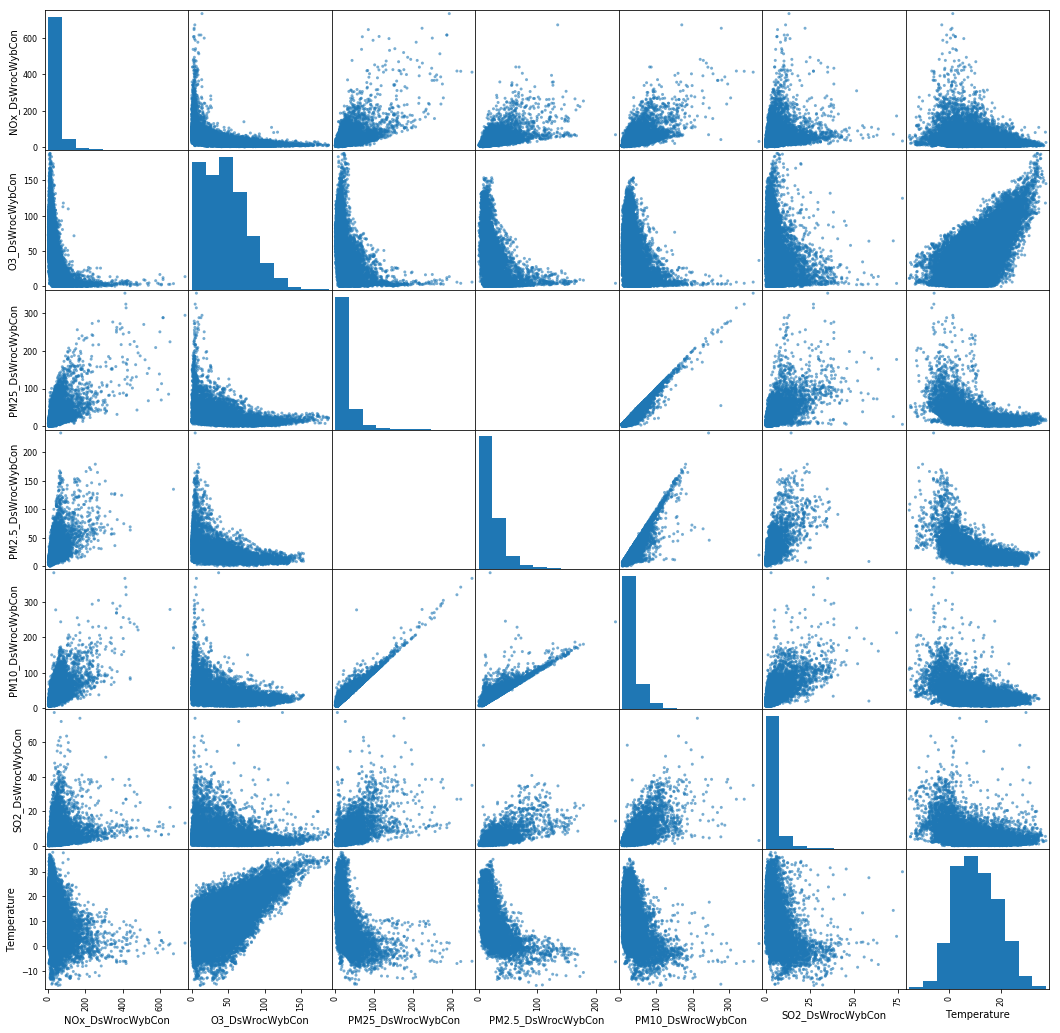

In [685]:
print(main_df.columns)
# pollution_factors = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM25', 'PM2.5', 'PM10', 'SO2']
pollution_factors = ['NOx', 'O3', 'PM25', 'PM2.5', 'PM10', 'SO2']
location = 'DsWrocWybCon'
features = ['{}_{}'.format(f, location) for f in pollution_factors if '{}_{}'.format(f, location) in main_df.columns]
features += ['Temperature']
data = main_df[features]
pd.plotting.scatter_matrix(data, alpha=0.6, figsize=(18, 18))
plt.show()


We can see a weird dependence between NO2 and NOx. However, it results from the fact, that NOx = NO2 + (other nitro oxides).

### 2.2. Show two time series of temperature and concetration of benzene in air.

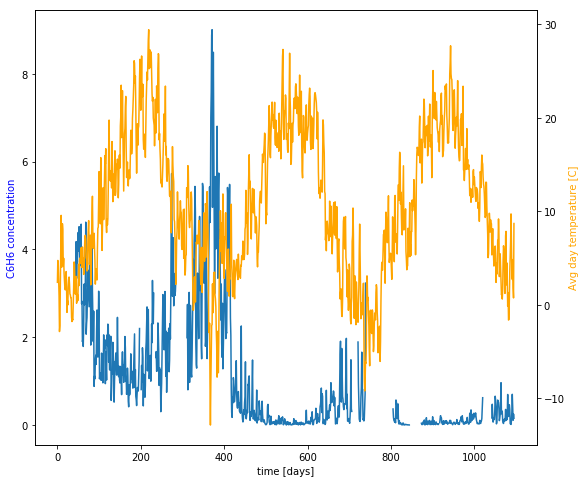

In [238]:
fig, ax1 = plt.subplots(figsize = (9,8))
ax1.plot(mean_day_df.index, mean_day_df['C6H6_DsWrocWybCon'])
ax1.set_xlabel('time [days]')
ax1.set_ylabel('C6H6 concentration', color='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Avg day temperature [C]', color='orange')
ax2.plot(mean_day_df.index, mean_day_df['Temperature'], color='orange')


In [722]:
def split(X, y):
    return model_selection.train_test_split(X, y, test_size=.25, random_state=42)

def analyze_LR(model, X_valid, y_valid):
    print("Mean squared error: %.2f"% mean_squared_error(y_valid, model.predict(X_valid)))
    print('R^2 score: %.2f' % r2_score(y_valid, model.predict(X_valid)))
    print(model.summary())
    x = np.arange(min(X_valid[:,1]), max(X_valid[:,1]))
    plt.plot(x, regr.predict(sm.add_constant(x)), color='red')
    plt.show()


Mean squared error: 2.16
R^2 score: 0.22
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 11 Feb 2019   Prob (F-statistic):           3.82e-23
Time:                        17:00:07   Log-Likelihood:                -1106.6
No. Observations:                 667   AIC:                             2217.
Df Residuals:                     665   BIC:                             2226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

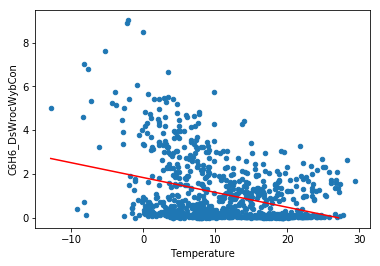

In [723]:
data = mean_day_df[['Temperature', 'C6H6_DsWrocWybCon']].dropna()
data.plot.scatter(x='Temperature', y='C6H6_DsWrocWybCon')
dataX, dataY = np.array(data['Temperature']).reshape(-1, 1), np.array(data['C6H6_DsWrocWybCon']).reshape(-1, 1)
dataX = sm.add_constant(dataX)
X_train, X_valid, y_train, y_valid = split(dataX, dataY)
regr = sm.OLS(y_train, X_train).fit()
analyze_LR(regr, X_valid, y_valid)


Mean squared error: 313.23
R^2 score: 0.28
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     276.8
Date:                Mon, 11 Feb 2019   Prob (F-statistic):           9.08e-54
Time:                        17:01:41   Log-Likelihood:                -3496.3
No. Observations:                 821   AIC:                             6997.
Df Residuals:                     819   BIC:                             7006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

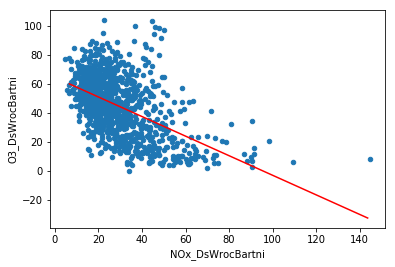

In [724]:
data = mean_day_df[['NOx_DsWrocBartni', 'O3_DsWrocBartni']].dropna()
data.plot.scatter(x='NOx_DsWrocBartni', y='O3_DsWrocBartni')
dataX, dataY = np.array(data['NOx_DsWrocBartni']).reshape(-1, 1), np.array(data['O3_DsWrocBartni']).reshape(-1, 1)
dataX = sm.add_constant(dataX)
X_train, X_valid, y_train, y_valid = split(dataX, dataY)
regr = sm.OLS(y_train, X_train).fit()
analyze_LR(regr, X_valid, y_valid)



# 3. Playing with RNN

I know that weather forecasting is not easy. This model is made for education, not to be super accurate. I've decided to use LSTM and try to predict weekly average temperature during 25 weeks after last measurement. The neural net is trained with data from 2 consecutive years. The third year is used as a validation data. To generate a prediction we have to feed the net with latest data from 24 weeks before started prediction.

In [751]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math


def timeseries_to_supervised(data, lag, forecast_seq):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+forecast_seq+1)] + [df]
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

def difference(dataset, interval=1):
    return (dataset - dataset.shift(interval).fillna(0))[1:]

def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(train.reshape(-1, 1))
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, value):
    array = np.array([value]).reshape(-1, 1)
    return list(scaler.inverse_transform(array))

def create_model(neurons, batch_size, X, forecast_seq):
    model = Sequential()
#     model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(forecast_seq))
    return model

def fit_lstm(train, batch_size, nb_epoch, neurons, forecast_seq):
    X, y = train[:, :-forecast_seq], train[:, -forecast_seq:]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = create_model(neurons, batch_size, X, forecast_seq)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False)
    new_model = create_model(neurons, 1, X, forecast_seq)
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)
    return new_model

def forecast_lstm(model, batch_size, X):
    return model.predict(X.reshape(1, len(X), 1), batch_size=batch_size)

def create_lstm_model_and_fit(series,
                              split_index,
                              predictors_lag,
                              batch_size,
                              epochs,
                              forecast_seq,
                              neurons):
    diff_values = difference(series)
    supervised = timeseries_to_supervised(diff_values, predictors_lag, forecast_seq)
    train, test = supervised.values[:split_index], supervised.values[split_index:]
    scaler, train_scaled, test_scaled = scale(train, test)
    lstm_model = fit_lstm(train_scaled, batch_size, epochs, neurons, forecast_seq)
    predictions = []
    for i in range(len(test_scaled)):
        X = test_scaled[i, :-forecast_seq]
        predicted = invert_scale(scaler, forecast_lstm(lstm_model, 1, X))
        predictions += [predicted]
    predictions = np.array(predictions)
    rmse = []
    for i in range(predictions.shape[1]):
        rmse += [math.sqrt(mean_squared_error(test[:, -forecast_seq+i], predictions[:, i]))]    
    print('Test max RMSE: %.3f' % np.max(rmse))
    print('Test min RMSE: %.3f' % np.min(rmse))


weekly_df = main_df.groupby(main_df.index // (24*7)).mean()
series = weekly_df['Temperature'].dropna()
split_index = 50
predictors_lag = 24
batch_size = 50
epochs = 5000
forecast_seq = 24
neurons = 200
create_lstm_model_and_fit(series,
                          split_index,
                          predictors_lag,
                          batch_size,
                          epochs,
                          forecast_seq,
                          neurons)


Epoch 1/5000
 - 56s - loss: 0.2393
Epoch 2/5000
 - 0s - loss: 0.2336
Epoch 3/5000
 - 0s - loss: 0.2279
Epoch 4/5000
 - 0s - loss: 0.2219
Epoch 5/5000
 - 0s - loss: 0.2149
Epoch 6/5000
 - 0s - loss: 0.2063
Epoch 7/5000
 - 0s - loss: 0.1960
Epoch 8/5000
 - 0s - loss: 0.1871
Epoch 9/5000
 - 0s - loss: 0.1959
Epoch 10/5000
 - 0s - loss: 0.1888
Epoch 11/5000
 - 0s - loss: 0.1819
Epoch 12/5000
 - 0s - loss: 0.1812
Epoch 13/5000
 - 0s - loss: 0.1825
Epoch 14/5000
 - 0s - loss: 0.1833
Epoch 15/5000
 - 0s - loss: 0.1831
Epoch 16/5000
 - 0s - loss: 0.1821
Epoch 17/5000
 - 0s - loss: 0.1810
Epoch 18/5000
 - 0s - loss: 0.1803
Epoch 19/5000
 - 0s - loss: 0.1805
Epoch 20/5000
 - 0s - loss: 0.1807
Epoch 21/5000
 - 0s - loss: 0.1802
Epoch 22/5000
 - 0s - loss: 0.1792
Epoch 23/5000
 - 0s - loss: 0.1784
Epoch 24/5000
 - 0s - loss: 0.1781
Epoch 25/5000
 - 0s - loss: 0.1781
Epoch 26/5000
 - 0s - loss: 0.1782
Epoch 27/5000
 - 0s - loss: 0.1781
Epoch 28/5000
 - 0s - loss: 0.1779
Epoch 29/5000
 - 0s - loss: 

Epoch 232/5000
 - 0s - loss: 0.1137
Epoch 233/5000
 - 0s - loss: 0.1134
Epoch 234/5000
 - 0s - loss: 0.1134
Epoch 235/5000
 - 0s - loss: 0.1130
Epoch 236/5000
 - 0s - loss: 0.1124
Epoch 237/5000
 - 0s - loss: 0.1122
Epoch 238/5000
 - 0s - loss: 0.1120
Epoch 239/5000
 - 0s - loss: 0.1117
Epoch 240/5000
 - 0s - loss: 0.1114
Epoch 241/5000
 - 0s - loss: 0.1110
Epoch 242/5000
 - 0s - loss: 0.1107
Epoch 243/5000
 - 0s - loss: 0.1105
Epoch 244/5000
 - 0s - loss: 0.1102
Epoch 245/5000
 - 0s - loss: 0.1099
Epoch 246/5000
 - 0s - loss: 0.1096
Epoch 247/5000
 - 0s - loss: 0.1094
Epoch 248/5000
 - 0s - loss: 0.1092
Epoch 249/5000
 - 0s - loss: 0.1090
Epoch 250/5000
 - 0s - loss: 0.1096
Epoch 251/5000
 - 0s - loss: 0.1151
Epoch 252/5000
 - 0s - loss: 0.1277
Epoch 253/5000
 - 0s - loss: 0.1099
Epoch 254/5000
 - 0s - loss: 0.1253
Epoch 255/5000
 - 0s - loss: 0.1160
Epoch 256/5000
 - 0s - loss: 0.1196
Epoch 257/5000
 - 0s - loss: 0.1110
Epoch 258/5000
 - 0s - loss: 0.1183
Epoch 259/5000
 - 0s - loss:

Epoch 460/5000
 - 0s - loss: 0.0348
Epoch 461/5000
 - 0s - loss: 0.0338
Epoch 462/5000
 - 0s - loss: 0.0346
Epoch 463/5000
 - 0s - loss: 0.0359
Epoch 464/5000
 - 0s - loss: 0.0359
Epoch 465/5000
 - 0s - loss: 0.0392
Epoch 466/5000
 - 0s - loss: 0.0433
Epoch 467/5000
 - 0s - loss: 0.0531
Epoch 468/5000
 - 0s - loss: 0.0700
Epoch 469/5000
 - 0s - loss: 0.0361
Epoch 470/5000
 - 0s - loss: 0.0589
Epoch 471/5000
 - 0s - loss: 0.0504
Epoch 472/5000
 - 0s - loss: 0.0469
Epoch 473/5000
 - 0s - loss: 0.0473
Epoch 474/5000
 - 0s - loss: 0.0390
Epoch 475/5000
 - 0s - loss: 0.0412
Epoch 476/5000
 - 0s - loss: 0.0366
Epoch 477/5000
 - 0s - loss: 0.0428
Epoch 478/5000
 - 0s - loss: 0.0341
Epoch 479/5000
 - 0s - loss: 0.0389
Epoch 480/5000
 - 0s - loss: 0.0333
Epoch 481/5000
 - 0s - loss: 0.0329
Epoch 482/5000
 - 0s - loss: 0.0338
Epoch 483/5000
 - 0s - loss: 0.0306
Epoch 484/5000
 - 0s - loss: 0.0320
Epoch 485/5000
 - 0s - loss: 0.0301
Epoch 486/5000
 - 0s - loss: 0.0286
Epoch 487/5000
 - 0s - loss:

 - 0s - loss: 0.0023
Epoch 687/5000
 - 0s - loss: 0.0030
Epoch 688/5000
 - 0s - loss: 0.0036
Epoch 689/5000
 - 0s - loss: 0.0034
Epoch 690/5000
 - 0s - loss: 0.0023
Epoch 691/5000
 - 0s - loss: 0.0010
Epoch 692/5000
 - 0s - loss: 9.7992e-04
Epoch 693/5000
 - 0s - loss: 0.0017
Epoch 694/5000
 - 0s - loss: 0.0019
Epoch 695/5000
 - 0s - loss: 0.0013
Epoch 696/5000
 - 0s - loss: 7.5521e-04
Epoch 697/5000
 - 0s - loss: 0.0011
Epoch 698/5000
 - 0s - loss: 0.0014
Epoch 699/5000
 - 0s - loss: 0.0011
Epoch 700/5000
 - 0s - loss: 6.3605e-04
Epoch 701/5000
 - 0s - loss: 7.6646e-04
Epoch 702/5000
 - 0s - loss: 0.0011
Epoch 703/5000
 - 0s - loss: 0.0010
Epoch 704/5000
 - 0s - loss: 6.1125e-04
Epoch 705/5000
 - 0s - loss: 5.8058e-04
Epoch 706/5000
 - 0s - loss: 8.3521e-04
Epoch 707/5000
 - 0s - loss: 8.2710e-04
Epoch 708/5000
 - 0s - loss: 5.8412e-04
Epoch 709/5000
 - 0s - loss: 5.0699e-04
Epoch 710/5000
 - 0s - loss: 6.3529e-04
Epoch 711/5000
 - 0s - loss: 6.6461e-04
Epoch 712/5000
 - 0s - loss: 5.

 - 0s - loss: 9.1107e-04
Epoch 899/5000
 - 0s - loss: 7.4966e-04
Epoch 900/5000
 - 0s - loss: 7.3372e-04
Epoch 901/5000
 - 0s - loss: 7.2996e-04
Epoch 902/5000
 - 0s - loss: 6.1702e-04
Epoch 903/5000
 - 0s - loss: 5.8054e-04
Epoch 904/5000
 - 0s - loss: 5.6739e-04
Epoch 905/5000
 - 0s - loss: 5.0148e-04
Epoch 906/5000
 - 0s - loss: 4.6233e-04
Epoch 907/5000
 - 0s - loss: 4.2831e-04
Epoch 908/5000
 - 0s - loss: 4.0470e-04
Epoch 909/5000
 - 0s - loss: 3.8432e-04
Epoch 910/5000
 - 0s - loss: 3.5148e-04
Epoch 911/5000
 - 0s - loss: 3.0352e-04
Epoch 912/5000
 - 0s - loss: 3.3282e-04
Epoch 913/5000
 - 0s - loss: 2.8746e-04
Epoch 914/5000
 - 0s - loss: 2.4942e-04
Epoch 915/5000
 - 0s - loss: 2.6718e-04
Epoch 916/5000
 - 0s - loss: 2.4903e-04
Epoch 917/5000
 - 0s - loss: 2.1223e-04
Epoch 918/5000
 - 0s - loss: 2.1283e-04
Epoch 919/5000
 - 0s - loss: 2.0296e-04
Epoch 920/5000
 - 0s - loss: 1.9011e-04
Epoch 921/5000
 - 0s - loss: 1.7547e-04
Epoch 922/5000
 - 0s - loss: 1.6536e-04
Epoch 923/5000


Epoch 1101/5000
 - 0s - loss: 1.2421e-06
Epoch 1102/5000
 - 0s - loss: 1.2180e-06
Epoch 1103/5000
 - 0s - loss: 1.1944e-06
Epoch 1104/5000
 - 0s - loss: 1.1713e-06
Epoch 1105/5000
 - 0s - loss: 1.1486e-06
Epoch 1106/5000
 - 0s - loss: 1.1264e-06
Epoch 1107/5000
 - 0s - loss: 1.1047e-06
Epoch 1108/5000
 - 0s - loss: 1.0833e-06
Epoch 1109/5000
 - 0s - loss: 1.0625e-06
Epoch 1110/5000
 - 0s - loss: 1.0420e-06
Epoch 1111/5000
 - 0s - loss: 1.0220e-06
Epoch 1112/5000
 - 0s - loss: 1.0024e-06
Epoch 1113/5000
 - 0s - loss: 9.8314e-07
Epoch 1114/5000
 - 0s - loss: 9.6430e-07
Epoch 1115/5000
 - 0s - loss: 9.4586e-07
Epoch 1116/5000
 - 0s - loss: 9.2778e-07
Epoch 1117/5000
 - 0s - loss: 9.1007e-07
Epoch 1118/5000
 - 0s - loss: 8.9272e-07
Epoch 1119/5000
 - 0s - loss: 8.7569e-07
Epoch 1120/5000
 - 0s - loss: 8.5902e-07
Epoch 1121/5000
 - 0s - loss: 8.4271e-07
Epoch 1122/5000
 - 0s - loss: 8.2667e-07
Epoch 1123/5000
 - 0s - loss: 8.1099e-07
Epoch 1124/5000
 - 0s - loss: 7.9560e-07
Epoch 1125/5000


Epoch 1301/5000
 - 0s - loss: 1.5620e-06
Epoch 1302/5000
 - 0s - loss: 1.1854e-06
Epoch 1303/5000
 - 0s - loss: 7.6580e-07
Epoch 1304/5000
 - 0s - loss: 4.0905e-07
Epoch 1305/5000
 - 0s - loss: 1.8005e-07
Epoch 1306/5000
 - 0s - loss: 9.3343e-08
Epoch 1307/5000
 - 0s - loss: 1.2736e-07
Epoch 1308/5000
 - 0s - loss: 2.4216e-07
Epoch 1309/5000
 - 0s - loss: 3.9119e-07
Epoch 1310/5000
 - 0s - loss: 5.2953e-07
Epoch 1311/5000
 - 0s - loss: 6.2896e-07
Epoch 1312/5000
 - 0s - loss: 6.7582e-07
Epoch 1313/5000
 - 0s - loss: 6.7064e-07
Epoch 1314/5000
 - 0s - loss: 6.1899e-07
Epoch 1315/5000
 - 0s - loss: 5.3881e-07
Epoch 1316/5000
 - 0s - loss: 4.4306e-07
Epoch 1317/5000
 - 0s - loss: 3.4480e-07
Epoch 1318/5000
 - 0s - loss: 2.5364e-07
Epoch 1319/5000
 - 0s - loss: 1.7776e-07
Epoch 1320/5000
 - 0s - loss: 1.1992e-07
Epoch 1321/5000
 - 0s - loss: 7.9746e-08
Epoch 1322/5000
 - 0s - loss: 5.5885e-08
Epoch 1323/5000
 - 0s - loss: 4.5737e-08
Epoch 1324/5000
 - 0s - loss: 4.5887e-08
Epoch 1325/5000


Epoch 1501/5000
 - 0s - loss: 7.3030e-09
Epoch 1502/5000
 - 0s - loss: 7.2339e-09
Epoch 1503/5000
 - 0s - loss: 7.1405e-09
Epoch 1504/5000
 - 0s - loss: 7.0223e-09
Epoch 1505/5000
 - 0s - loss: 6.8790e-09
Epoch 1506/5000
 - 0s - loss: 6.7154e-09
Epoch 1507/5000
 - 0s - loss: 6.5359e-09
Epoch 1508/5000
 - 0s - loss: 6.3424e-09
Epoch 1509/5000
 - 0s - loss: 6.1525e-09
Epoch 1510/5000
 - 0s - loss: 5.9620e-09
Epoch 1511/5000
 - 0s - loss: 5.7798e-09
Epoch 1512/5000
 - 0s - loss: 5.6015e-09
Epoch 1513/5000
 - 0s - loss: 5.4311e-09
Epoch 1514/5000
 - 0s - loss: 5.2730e-09
Epoch 1515/5000
 - 0s - loss: 5.1258e-09
Epoch 1516/5000
 - 0s - loss: 4.9929e-09
Epoch 1517/5000
 - 0s - loss: 4.8717e-09
Epoch 1518/5000
 - 0s - loss: 4.7613e-09
Epoch 1519/5000
 - 0s - loss: 4.6657e-09
Epoch 1520/5000
 - 0s - loss: 4.5863e-09
Epoch 1521/5000
 - 0s - loss: 4.5244e-09
Epoch 1522/5000
 - 0s - loss: 4.4862e-09
Epoch 1523/5000
 - 0s - loss: 4.4784e-09
Epoch 1524/5000
 - 0s - loss: 4.5080e-09
Epoch 1525/5000


 - 0s - loss: 1.2667e-07
Epoch 1703/5000
 - 0s - loss: 1.2382e-07
Epoch 1704/5000
 - 0s - loss: 1.1823e-07
Epoch 1705/5000
 - 0s - loss: 1.1557e-07
Epoch 1706/5000
 - 0s - loss: 1.1099e-07
Epoch 1707/5000
 - 0s - loss: 1.0762e-07
Epoch 1708/5000
 - 0s - loss: 1.0438e-07
Epoch 1709/5000
 - 0s - loss: 1.0040e-07
Epoch 1710/5000
 - 0s - loss: 9.7915e-08
Epoch 1711/5000
 - 0s - loss: 9.4076e-08
Epoch 1712/5000
 - 0s - loss: 9.1586e-08
Epoch 1713/5000
 - 0s - loss: 8.8449e-08
Epoch 1714/5000
 - 0s - loss: 8.5639e-08
Epoch 1715/5000
 - 0s - loss: 8.3156e-08
Epoch 1716/5000
 - 0s - loss: 8.0268e-08
Epoch 1717/5000
 - 0s - loss: 7.8038e-08
Epoch 1718/5000
 - 0s - loss: 7.5441e-08
Epoch 1719/5000
 - 0s - loss: 7.3200e-08
Epoch 1720/5000
 - 0s - loss: 7.0975e-08
Epoch 1721/5000
 - 0s - loss: 6.8714e-08
Epoch 1722/5000
 - 0s - loss: 6.6734e-08
Epoch 1723/5000
 - 0s - loss: 6.4634e-08
Epoch 1724/5000
 - 0s - loss: 6.2704e-08
Epoch 1725/5000
 - 0s - loss: 6.0859e-08
Epoch 1726/5000
 - 0s - loss: 5.

 - 0s - loss: 7.1604e-10
Epoch 1903/5000
 - 0s - loss: 7.0071e-10
Epoch 1904/5000
 - 0s - loss: 6.8476e-10
Epoch 1905/5000
 - 0s - loss: 6.7007e-10
Epoch 1906/5000
 - 0s - loss: 6.5513e-10
Epoch 1907/5000
 - 0s - loss: 6.4076e-10
Epoch 1908/5000
 - 0s - loss: 6.2588e-10
Epoch 1909/5000
 - 0s - loss: 6.1227e-10
Epoch 1910/5000
 - 0s - loss: 5.9860e-10
Epoch 1911/5000
 - 0s - loss: 5.8508e-10
Epoch 1912/5000
 - 0s - loss: 5.7152e-10
Epoch 1913/5000
 - 0s - loss: 5.5951e-10
Epoch 1914/5000
 - 0s - loss: 5.4752e-10
Epoch 1915/5000
 - 0s - loss: 5.3526e-10
Epoch 1916/5000
 - 0s - loss: 5.2274e-10
Epoch 1917/5000
 - 0s - loss: 5.1138e-10
Epoch 1918/5000
 - 0s - loss: 5.0023e-10
Epoch 1919/5000
 - 0s - loss: 4.8900e-10
Epoch 1920/5000
 - 0s - loss: 4.7850e-10
Epoch 1921/5000
 - 0s - loss: 4.6770e-10
Epoch 1922/5000
 - 0s - loss: 4.5713e-10
Epoch 1923/5000
 - 0s - loss: 4.4701e-10
Epoch 1924/5000
 - 0s - loss: 4.3713e-10
Epoch 1925/5000
 - 0s - loss: 4.2773e-10
Epoch 1926/5000
 - 0s - loss: 4.

 - 0s - loss: 8.7829e-12
Epoch 2103/5000
 - 0s - loss: 8.6068e-12
Epoch 2104/5000
 - 0s - loss: 8.4466e-12
Epoch 2105/5000
 - 0s - loss: 8.2399e-12
Epoch 2106/5000
 - 0s - loss: 8.0759e-12
Epoch 2107/5000
 - 0s - loss: 7.8569e-12
Epoch 2108/5000
 - 0s - loss: 7.7483e-12
Epoch 2109/5000
 - 0s - loss: 7.6188e-12
Epoch 2110/5000
 - 0s - loss: 7.4257e-12
Epoch 2111/5000
 - 0s - loss: 7.2555e-12
Epoch 2112/5000
 - 0s - loss: 7.0698e-12
Epoch 2113/5000
 - 0s - loss: 6.9709e-12
Epoch 2114/5000
 - 0s - loss: 6.7926e-12
Epoch 2115/5000
 - 0s - loss: 6.6903e-12
Epoch 2116/5000
 - 0s - loss: 6.5603e-12
Epoch 2117/5000
 - 0s - loss: 6.4167e-12
Epoch 2118/5000
 - 0s - loss: 6.3319e-12
Epoch 2119/5000
 - 0s - loss: 6.1176e-12
Epoch 2120/5000
 - 0s - loss: 6.0297e-12
Epoch 2121/5000
 - 0s - loss: 5.8777e-12
Epoch 2122/5000
 - 0s - loss: 5.7502e-12
Epoch 2123/5000
 - 0s - loss: 5.6376e-12
Epoch 2124/5000
 - 0s - loss: 5.5232e-12
Epoch 2125/5000
 - 0s - loss: 5.4343e-12
Epoch 2126/5000
 - 0s - loss: 5.

 - 0s - loss: 2.7189e-13
Epoch 2303/5000
 - 0s - loss: 2.6908e-13
Epoch 2304/5000
 - 0s - loss: 2.8212e-13
Epoch 2305/5000
 - 0s - loss: 2.6540e-13
Epoch 2306/5000
 - 0s - loss: 2.6043e-13
Epoch 2307/5000
 - 0s - loss: 2.5673e-13
Epoch 2308/5000
 - 0s - loss: 2.5265e-13
Epoch 2309/5000
 - 0s - loss: 2.5565e-13
Epoch 2310/5000
 - 0s - loss: 2.5271e-13
Epoch 2311/5000
 - 0s - loss: 2.4273e-13
Epoch 2312/5000
 - 0s - loss: 2.4581e-13
Epoch 2313/5000
 - 0s - loss: 2.4159e-13
Epoch 2314/5000
 - 0s - loss: 2.3555e-13
Epoch 2315/5000
 - 0s - loss: 2.3800e-13
Epoch 2316/5000
 - 0s - loss: 2.3338e-13
Epoch 2317/5000
 - 0s - loss: 2.3670e-13
Epoch 2318/5000
 - 0s - loss: 2.3333e-13
Epoch 2319/5000
 - 0s - loss: 2.2044e-13
Epoch 2320/5000
 - 0s - loss: 2.2382e-13
Epoch 2321/5000
 - 0s - loss: 2.2361e-13
Epoch 2322/5000
 - 0s - loss: 2.1026e-13
Epoch 2323/5000
 - 0s - loss: 2.0874e-13
Epoch 2324/5000
 - 0s - loss: 2.0799e-13
Epoch 2325/5000
 - 0s - loss: 2.0783e-13
Epoch 2326/5000
 - 0s - loss: 2.

 - 0s - loss: 5.2767e-14
Epoch 2503/5000
 - 0s - loss: 5.6077e-14
Epoch 2504/5000
 - 0s - loss: 5.3171e-14
Epoch 2505/5000
 - 0s - loss: 5.8723e-14
Epoch 2506/5000
 - 0s - loss: 5.4992e-14
Epoch 2507/5000
 - 0s - loss: 5.1757e-14
Epoch 2508/5000
 - 0s - loss: 5.2845e-14
Epoch 2509/5000
 - 0s - loss: 5.2750e-14
Epoch 2510/5000
 - 0s - loss: 5.5263e-14
Epoch 2511/5000
 - 0s - loss: 4.8570e-14
Epoch 2512/5000
 - 0s - loss: 5.5102e-14
Epoch 2513/5000
 - 0s - loss: 5.2944e-14
Epoch 2514/5000
 - 0s - loss: 5.2465e-14
Epoch 2515/5000
 - 0s - loss: 5.4003e-14
Epoch 2516/5000
 - 0s - loss: 5.3652e-14
Epoch 2517/5000
 - 0s - loss: 5.3101e-14
Epoch 2518/5000
 - 0s - loss: 5.3544e-14
Epoch 2519/5000
 - 0s - loss: 5.0541e-14
Epoch 2520/5000
 - 0s - loss: 5.3374e-14
Epoch 2521/5000
 - 0s - loss: 4.8937e-14
Epoch 2522/5000
 - 0s - loss: 5.5606e-14
Epoch 2523/5000
 - 0s - loss: 5.3083e-14
Epoch 2524/5000
 - 0s - loss: 5.4280e-14
Epoch 2525/5000
 - 0s - loss: 5.0835e-14
Epoch 2526/5000
 - 0s - loss: 5.

 - 0s - loss: 3.7241e-14
Epoch 2703/5000
 - 0s - loss: 3.9603e-14
Epoch 2704/5000
 - 0s - loss: 4.0445e-14
Epoch 2705/5000
 - 0s - loss: 3.8819e-14
Epoch 2706/5000
 - 0s - loss: 3.9468e-14
Epoch 2707/5000
 - 0s - loss: 4.0001e-14
Epoch 2708/5000
 - 0s - loss: 4.0508e-14
Epoch 2709/5000
 - 0s - loss: 4.3320e-14
Epoch 2710/5000
 - 0s - loss: 4.1287e-14
Epoch 2711/5000
 - 0s - loss: 4.5040e-14
Epoch 2712/5000
 - 0s - loss: 3.9289e-14
Epoch 2713/5000
 - 0s - loss: 4.4355e-14
Epoch 2714/5000
 - 0s - loss: 4.2892e-14
Epoch 2715/5000
 - 0s - loss: 3.7918e-14
Epoch 2716/5000
 - 0s - loss: 4.6287e-14
Epoch 2717/5000
 - 0s - loss: 3.6174e-14
Epoch 2718/5000
 - 0s - loss: 4.0996e-14
Epoch 2719/5000
 - 0s - loss: 3.5742e-14
Epoch 2720/5000
 - 0s - loss: 3.7931e-14
Epoch 2721/5000
 - 0s - loss: 3.7227e-14
Epoch 2722/5000
 - 0s - loss: 4.5457e-14
Epoch 2723/5000
 - 0s - loss: 3.7302e-14
Epoch 2724/5000
 - 0s - loss: 4.6050e-14
Epoch 2725/5000
 - 0s - loss: 3.8520e-14
Epoch 2726/5000
 - 0s - loss: 4.

 - 0s - loss: 5.6453e-14
Epoch 2903/5000
 - 0s - loss: 4.4087e-14
Epoch 2904/5000
 - 0s - loss: 4.2732e-14
Epoch 2905/5000
 - 0s - loss: 4.8772e-14
Epoch 2906/5000
 - 0s - loss: 3.9191e-14
Epoch 2907/5000
 - 0s - loss: 5.1233e-14
Epoch 2908/5000
 - 0s - loss: 4.7160e-14
Epoch 2909/5000
 - 0s - loss: 4.2050e-14
Epoch 2910/5000
 - 0s - loss: 4.6088e-14
Epoch 2911/5000
 - 0s - loss: 4.7332e-14
Epoch 2912/5000
 - 0s - loss: 4.5244e-14
Epoch 2913/5000
 - 0s - loss: 4.2287e-14
Epoch 2914/5000
 - 0s - loss: 5.7023e-14
Epoch 2915/5000
 - 0s - loss: 3.6377e-14
Epoch 2916/5000
 - 0s - loss: 5.5323e-14
Epoch 2917/5000
 - 0s - loss: 4.0095e-14
Epoch 2918/5000
 - 0s - loss: 5.8890e-14
Epoch 2919/5000
 - 0s - loss: 4.6853e-14
Epoch 2920/5000
 - 0s - loss: 6.3340e-14
Epoch 2921/5000
 - 0s - loss: 4.4342e-14
Epoch 2922/5000
 - 0s - loss: 5.5450e-14
Epoch 2923/5000
 - 0s - loss: 3.9741e-14
Epoch 2924/5000
 - 0s - loss: 4.4596e-14
Epoch 2925/5000
 - 0s - loss: 3.7583e-14
Epoch 2926/5000
 - 0s - loss: 4.

Epoch 3114/5000
 - 0s - loss: 0.0525
Epoch 3115/5000
 - 0s - loss: 0.0462
Epoch 3116/5000
 - 0s - loss: 0.0439
Epoch 3117/5000
 - 0s - loss: 0.0413
Epoch 3118/5000
 - 0s - loss: 0.0426
Epoch 3119/5000
 - 0s - loss: 0.0478
Epoch 3120/5000
 - 0s - loss: 0.0514
Epoch 3121/5000
 - 0s - loss: 0.0483
Epoch 3122/5000
 - 0s - loss: 0.0382
Epoch 3123/5000
 - 0s - loss: 0.0441
Epoch 3124/5000
 - 0s - loss: 0.0459
Epoch 3125/5000
 - 0s - loss: 0.0395
Epoch 3126/5000
 - 0s - loss: 0.0376
Epoch 3127/5000
 - 0s - loss: 0.0382
Epoch 3128/5000
 - 0s - loss: 0.0379
Epoch 3129/5000
 - 0s - loss: 0.0368
Epoch 3130/5000
 - 0s - loss: 0.0333
Epoch 3131/5000
 - 0s - loss: 0.0357
Epoch 3132/5000
 - 0s - loss: 0.0331
Epoch 3133/5000
 - 0s - loss: 0.0317
Epoch 3134/5000
 - 0s - loss: 0.0330
Epoch 3135/5000
 - 0s - loss: 0.0302
Epoch 3136/5000
 - 0s - loss: 0.0300
Epoch 3137/5000
 - 0s - loss: 0.0294
Epoch 3138/5000
 - 0s - loss: 0.0281
Epoch 3139/5000
 - 0s - loss: 0.0294
Epoch 3140/5000
 - 0s - loss: 0.0279
E

Epoch 3330/5000
 - 0s - loss: 2.5611e-04
Epoch 3331/5000
 - 0s - loss: 2.6577e-04
Epoch 3332/5000
 - 0s - loss: 2.7363e-04
Epoch 3333/5000
 - 0s - loss: 2.7515e-04
Epoch 3334/5000
 - 0s - loss: 2.6165e-04
Epoch 3335/5000
 - 0s - loss: 2.4270e-04
Epoch 3336/5000
 - 0s - loss: 2.2372e-04
Epoch 3337/5000
 - 0s - loss: 2.0908e-04
Epoch 3338/5000
 - 0s - loss: 2.0151e-04
Epoch 3339/5000
 - 0s - loss: 2.0127e-04
Epoch 3340/5000
 - 0s - loss: 2.0439e-04
Epoch 3341/5000
 - 0s - loss: 2.0642e-04
Epoch 3342/5000
 - 0s - loss: 2.0581e-04
Epoch 3343/5000
 - 0s - loss: 2.0207e-04
Epoch 3344/5000
 - 0s - loss: 1.9669e-04
Epoch 3345/5000
 - 0s - loss: 1.8819e-04
Epoch 3346/5000
 - 0s - loss: 1.8046e-04
Epoch 3347/5000
 - 0s - loss: 1.7247e-04
Epoch 3348/5000
 - 0s - loss: 1.6486e-04
Epoch 3349/5000
 - 0s - loss: 1.5847e-04
Epoch 3350/5000
 - 0s - loss: 1.5361e-04
Epoch 3351/5000
 - 0s - loss: 1.4989e-04
Epoch 3352/5000
 - 0s - loss: 1.4643e-04
Epoch 3353/5000
 - 0s - loss: 1.4399e-04
Epoch 3354/5000


Epoch 3530/5000
 - 0s - loss: 7.1055e-06
Epoch 3531/5000
 - 0s - loss: 5.2825e-06
Epoch 3532/5000
 - 0s - loss: 4.8666e-06
Epoch 3533/5000
 - 0s - loss: 6.0751e-06
Epoch 3534/5000
 - 0s - loss: 7.7968e-06
Epoch 3535/5000
 - 0s - loss: 8.9207e-06
Epoch 3536/5000
 - 0s - loss: 9.6245e-06
Epoch 3537/5000
 - 0s - loss: 1.0838e-05
Epoch 3538/5000
 - 0s - loss: 1.4184e-05
Epoch 3539/5000
 - 0s - loss: 2.0603e-05
Epoch 3540/5000
 - 0s - loss: 3.0673e-05
Epoch 3541/5000
 - 0s - loss: 4.7137e-05
Epoch 3542/5000
 - 0s - loss: 7.1897e-05
Epoch 3543/5000
 - 0s - loss: 1.1524e-04
Epoch 3544/5000
 - 0s - loss: 1.8219e-04
Epoch 3545/5000
 - 0s - loss: 2.9635e-04
Epoch 3546/5000
 - 0s - loss: 4.6157e-04
Epoch 3547/5000
 - 0s - loss: 7.1587e-04
Epoch 3548/5000
 - 0s - loss: 0.0010
Epoch 3549/5000
 - 0s - loss: 0.0014
Epoch 3550/5000
 - 0s - loss: 0.0015
Epoch 3551/5000
 - 0s - loss: 0.0013
Epoch 3552/5000
 - 0s - loss: 7.7029e-04
Epoch 3553/5000
 - 0s - loss: 1.9211e-04
Epoch 3554/5000
 - 0s - loss: 1.

 - 0s - loss: 1.0743e-07
Epoch 3731/5000
 - 0s - loss: 1.0544e-07
Epoch 3732/5000
 - 0s - loss: 1.0350e-07
Epoch 3733/5000
 - 0s - loss: 1.0159e-07
Epoch 3734/5000
 - 0s - loss: 9.9694e-08
Epoch 3735/5000
 - 0s - loss: 9.7839e-08
Epoch 3736/5000
 - 0s - loss: 9.6019e-08
Epoch 3737/5000
 - 0s - loss: 9.4270e-08
Epoch 3738/5000
 - 0s - loss: 9.2566e-08
Epoch 3739/5000
 - 0s - loss: 9.0863e-08
Epoch 3740/5000
 - 0s - loss: 8.9187e-08
Epoch 3741/5000
 - 0s - loss: 8.7574e-08
Epoch 3742/5000
 - 0s - loss: 8.5998e-08
Epoch 3743/5000
 - 0s - loss: 8.4481e-08
Epoch 3744/5000
 - 0s - loss: 8.3020e-08
Epoch 3745/5000
 - 0s - loss: 8.1636e-08
Epoch 3746/5000
 - 0s - loss: 8.0345e-08
Epoch 3747/5000
 - 0s - loss: 7.9197e-08
Epoch 3748/5000
 - 0s - loss: 7.8237e-08
Epoch 3749/5000
 - 0s - loss: 7.7548e-08
Epoch 3750/5000
 - 0s - loss: 7.7233e-08
Epoch 3751/5000
 - 0s - loss: 7.7541e-08
Epoch 3752/5000
 - 0s - loss: 7.8729e-08
Epoch 3753/5000
 - 0s - loss: 8.1288e-08
Epoch 3754/5000
 - 0s - loss: 8.

Epoch 3931/5000
 - 0s - loss: 2.1568e-04
Epoch 3932/5000
 - 0s - loss: 3.2784e-04
Epoch 3933/5000
 - 0s - loss: 4.7398e-04
Epoch 3934/5000
 - 0s - loss: 6.7732e-04
Epoch 3935/5000
 - 0s - loss: 8.8272e-04
Epoch 3936/5000
 - 0s - loss: 0.0011
Epoch 3937/5000
 - 0s - loss: 0.0011
Epoch 3938/5000
 - 0s - loss: 9.4576e-04
Epoch 3939/5000
 - 0s - loss: 4.9501e-04
Epoch 3940/5000
 - 0s - loss: 8.6743e-05
Epoch 3941/5000
 - 0s - loss: 8.6346e-05
Epoch 3942/5000
 - 0s - loss: 3.7309e-04
Epoch 3943/5000
 - 0s - loss: 5.2786e-04
Epoch 3944/5000
 - 0s - loss: 3.8505e-04
Epoch 3945/5000
 - 0s - loss: 1.1070e-04
Epoch 3946/5000
 - 0s - loss: 2.8837e-05
Epoch 3947/5000
 - 0s - loss: 1.8435e-04
Epoch 3948/5000
 - 0s - loss: 2.9692e-04
Epoch 3949/5000
 - 0s - loss: 1.9509e-04
Epoch 3950/5000
 - 0s - loss: 4.1408e-05
Epoch 3951/5000
 - 0s - loss: 3.4495e-05
Epoch 3952/5000
 - 0s - loss: 1.4167e-04
Epoch 3953/5000
 - 0s - loss: 1.7496e-04
Epoch 3954/5000
 - 0s - loss: 8.3252e-05
Epoch 3955/5000
 - 0s - 

 - 0s - loss: 1.9373e-09
Epoch 4132/5000
 - 0s - loss: 1.8917e-09
Epoch 4133/5000
 - 0s - loss: 1.8478e-09
Epoch 4134/5000
 - 0s - loss: 1.8028e-09
Epoch 4135/5000
 - 0s - loss: 1.7609e-09
Epoch 4136/5000
 - 0s - loss: 1.7185e-09
Epoch 4137/5000
 - 0s - loss: 1.6792e-09
Epoch 4138/5000
 - 0s - loss: 1.6394e-09
Epoch 4139/5000
 - 0s - loss: 1.6017e-09
Epoch 4140/5000
 - 0s - loss: 1.5652e-09
Epoch 4141/5000
 - 0s - loss: 1.5289e-09
Epoch 4142/5000
 - 0s - loss: 1.4948e-09
Epoch 4143/5000
 - 0s - loss: 1.4595e-09
Epoch 4144/5000
 - 0s - loss: 1.4255e-09
Epoch 4145/5000
 - 0s - loss: 1.3934e-09
Epoch 4146/5000
 - 0s - loss: 1.3622e-09
Epoch 4147/5000
 - 0s - loss: 1.3315e-09
Epoch 4148/5000
 - 0s - loss: 1.3013e-09
Epoch 4149/5000
 - 0s - loss: 1.2715e-09
Epoch 4150/5000
 - 0s - loss: 1.2429e-09
Epoch 4151/5000
 - 0s - loss: 1.2149e-09
Epoch 4152/5000
 - 0s - loss: 1.1880e-09
Epoch 4153/5000
 - 0s - loss: 1.1609e-09
Epoch 4154/5000
 - 0s - loss: 1.1357e-09
Epoch 4155/5000
 - 0s - loss: 1.

 - 0s - loss: 4.1934e-04
Epoch 4337/5000
 - 0s - loss: 3.9044e-04
Epoch 4338/5000
 - 0s - loss: 3.6741e-04
Epoch 4339/5000
 - 0s - loss: 3.3631e-04
Epoch 4340/5000
 - 0s - loss: 3.1808e-04
Epoch 4341/5000
 - 0s - loss: 2.9870e-04
Epoch 4342/5000
 - 0s - loss: 2.7991e-04
Epoch 4343/5000
 - 0s - loss: 2.5173e-04
Epoch 4344/5000
 - 0s - loss: 2.4914e-04
Epoch 4345/5000
 - 0s - loss: 2.3353e-04
Epoch 4346/5000
 - 0s - loss: 2.1529e-04
Epoch 4347/5000
 - 0s - loss: 2.0097e-04
Epoch 4348/5000
 - 0s - loss: 1.8516e-04
Epoch 4349/5000
 - 0s - loss: 1.7835e-04
Epoch 4350/5000
 - 0s - loss: 1.6388e-04
Epoch 4351/5000
 - 0s - loss: 1.6112e-04
Epoch 4352/5000
 - 0s - loss: 1.4858e-04
Epoch 4353/5000
 - 0s - loss: 1.3761e-04
Epoch 4354/5000
 - 0s - loss: 1.3120e-04
Epoch 4355/5000
 - 0s - loss: 1.2577e-04
Epoch 4356/5000
 - 0s - loss: 1.2128e-04
Epoch 4357/5000
 - 0s - loss: 1.1027e-04
Epoch 4358/5000
 - 0s - loss: 1.0795e-04
Epoch 4359/5000
 - 0s - loss: 9.9609e-05
Epoch 4360/5000
 - 0s - loss: 9.

 - 0s - loss: 5.7353e-07
Epoch 4537/5000
 - 0s - loss: 5.6113e-07
Epoch 4538/5000
 - 0s - loss: 5.4903e-07
Epoch 4539/5000
 - 0s - loss: 5.3721e-07
Epoch 4540/5000
 - 0s - loss: 5.2565e-07
Epoch 4541/5000
 - 0s - loss: 5.1436e-07
Epoch 4542/5000
 - 0s - loss: 5.0331e-07
Epoch 4543/5000
 - 0s - loss: 4.9254e-07
Epoch 4544/5000
 - 0s - loss: 4.8200e-07
Epoch 4545/5000
 - 0s - loss: 4.7170e-07
Epoch 4546/5000
 - 0s - loss: 4.6163e-07
Epoch 4547/5000
 - 0s - loss: 4.5179e-07
Epoch 4548/5000
 - 0s - loss: 4.4217e-07
Epoch 4549/5000
 - 0s - loss: 4.3276e-07
Epoch 4550/5000
 - 0s - loss: 4.2358e-07
Epoch 4551/5000
 - 0s - loss: 4.1460e-07
Epoch 4552/5000
 - 0s - loss: 4.0583e-07
Epoch 4553/5000
 - 0s - loss: 3.9726e-07
Epoch 4554/5000
 - 0s - loss: 3.8887e-07
Epoch 4555/5000
 - 0s - loss: 3.8067e-07
Epoch 4556/5000
 - 0s - loss: 3.7264e-07
Epoch 4557/5000
 - 0s - loss: 3.6479e-07
Epoch 4558/5000
 - 0s - loss: 3.5713e-07
Epoch 4559/5000
 - 0s - loss: 3.4963e-07
Epoch 4560/5000
 - 0s - loss: 3.

 - 0s - loss: 1.0556e-08
Epoch 4737/5000
 - 0s - loss: 1.0359e-08
Epoch 4738/5000
 - 0s - loss: 1.0167e-08
Epoch 4739/5000
 - 0s - loss: 9.9753e-09
Epoch 4740/5000
 - 0s - loss: 9.7893e-09
Epoch 4741/5000
 - 0s - loss: 9.6063e-09
Epoch 4742/5000
 - 0s - loss: 9.4251e-09
Epoch 4743/5000
 - 0s - loss: 9.2490e-09
Epoch 4744/5000
 - 0s - loss: 9.0776e-09
Epoch 4745/5000
 - 0s - loss: 8.9089e-09
Epoch 4746/5000
 - 0s - loss: 8.7401e-09
Epoch 4747/5000
 - 0s - loss: 8.5772e-09
Epoch 4748/5000
 - 0s - loss: 8.4160e-09
Epoch 4749/5000
 - 0s - loss: 8.2614e-09
Epoch 4750/5000
 - 0s - loss: 8.1077e-09
Epoch 4751/5000
 - 0s - loss: 7.9552e-09
Epoch 4752/5000
 - 0s - loss: 7.8066e-09
Epoch 4753/5000
 - 0s - loss: 7.6615e-09
Epoch 4754/5000
 - 0s - loss: 7.5183e-09
Epoch 4755/5000
 - 0s - loss: 7.3774e-09
Epoch 4756/5000
 - 0s - loss: 7.2401e-09
Epoch 4757/5000
 - 0s - loss: 7.1056e-09
Epoch 4758/5000
 - 0s - loss: 6.9727e-09
Epoch 4759/5000
 - 0s - loss: 6.8432e-09
Epoch 4760/5000
 - 0s - loss: 6.

 - 0s - loss: 2.5527e-10
Epoch 4937/5000
 - 0s - loss: 2.5067e-10
Epoch 4938/5000
 - 0s - loss: 2.4599e-10
Epoch 4939/5000
 - 0s - loss: 2.4186e-10
Epoch 4940/5000
 - 0s - loss: 2.3727e-10
Epoch 4941/5000
 - 0s - loss: 2.3322e-10
Epoch 4942/5000
 - 0s - loss: 2.2863e-10
Epoch 4943/5000
 - 0s - loss: 2.2453e-10
Epoch 4944/5000
 - 0s - loss: 2.2027e-10
Epoch 4945/5000
 - 0s - loss: 2.1657e-10
Epoch 4946/5000
 - 0s - loss: 2.1267e-10
Epoch 4947/5000
 - 0s - loss: 2.0882e-10
Epoch 4948/5000
 - 0s - loss: 2.0481e-10
Epoch 4949/5000
 - 0s - loss: 2.0111e-10
Epoch 4950/5000
 - 0s - loss: 1.9745e-10
Epoch 4951/5000
 - 0s - loss: 1.9380e-10
Epoch 4952/5000
 - 0s - loss: 1.9003e-10
Epoch 4953/5000
 - 0s - loss: 1.8680e-10
Epoch 4954/5000
 - 0s - loss: 1.8328e-10
Epoch 4955/5000
 - 0s - loss: 1.8003e-10
Epoch 4956/5000
 - 0s - loss: 1.7659e-10
Epoch 4957/5000
 - 0s - loss: 1.7350e-10
Epoch 4958/5000
 - 0s - loss: 1.7053e-10
Epoch 4959/5000
 - 0s - loss: 1.6717e-10
Epoch 4960/5000
 - 0s - loss: 1.

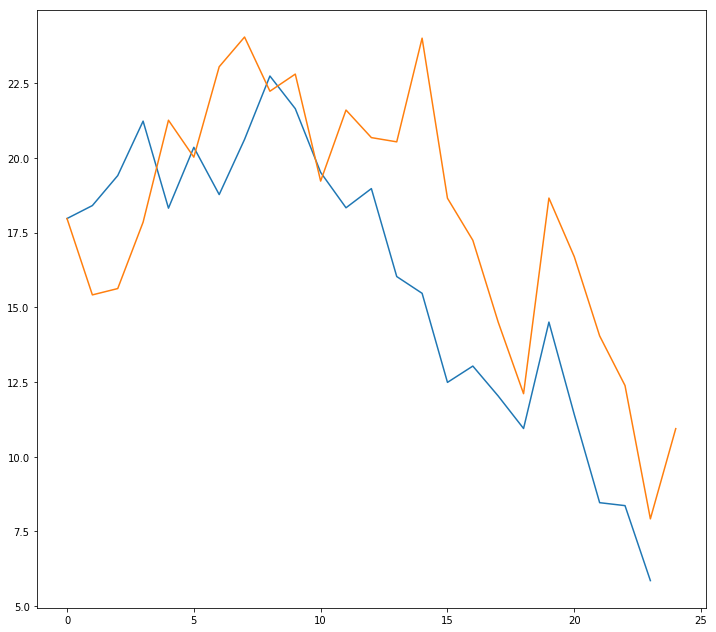

In [767]:
week = 126
fig = plt.figure(figsize=(12, 11))
plt.plot(series.values[week:week+forecast_seq])
diff_predictors = difference(series[week - predictors_lag-1 : week+1])
input = np.array(diff_predictors).reshape(-1, 1)
output = invert_scale(scaler, forecast_lstm(lstm_model, 1, scaler.transform(input)))
# output = invert_scale(scaler, forecast_lstm(lstm_model, 1, scaler.transform(np.array([0] + list(output)).reshape(-1, 1) )))
# output = invert_scale(scaler, forecast_lstm(lstm_model, 1, scaler.transform(np.array([0] + list(output)).reshape(-1, 1) )))
plt.plot( pd.Series.cumsum(pd.DataFrame( [series.values[week]] + list(output) )) )
plt.show()
